# **Computer Vision 600.661: Homework 2**
## **2D Transformations**

### Dimitri Lezcano

### **Imports**

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import cv2
import matplotlib.pyplot as plt


### **Short Answers**

#### 1) Load source points from 1a.npy and matching target points from 1b.npy, all of which are correct, compute the corresponding affine transformations or indicate that it is not possible to and why


*1a.npy and 1b.npy both contain a 10x3 array where each row is a 3D point. The first row
of 1a.npy matches the first row of 1b.npy; The second row of 1a.npy matches the second
row of 1b.npy and so forth. You will need numpy.load() to load data points. Note that to
check if a value x is equal to 1, you may use $abs(x-1)<eps$ instead of $x==1$.*

Load the source and target points

In [2]:
source_1 = np.load('short_questions/1a.npy')
target_1 = np.load('short_questions/1b.npy')
print(source_1.shape, target_1.shape)

(10, 2) (10, 2)


Functions for creating 2-D affine tensor

In [3]:
def affine_2d_Ab(X, Y):
    ''' create the A matrix for affine transformation
    
        Args:
            - X: the source points ( N x 2 )
            - Y: the target points ( N x 2 )
            
        Returns:
            - A: the A (2*N x 6) matrix for least squares formulation
            - b: the b (2*N) vector for least squares formulation
    
    '''
    # initialize the matrices
    A = np.zeros( ( 2*X.shape[0], 6 ) )
    b = Y.reshape(-1)
    
    Xh = np.hstack( ( X, np.ones( ( X.shape[0], 1 ) ) ) )
#     Yh = np.hstack( ( Y, np.ones( ( X.shape[0], 1 ) ) ) )

    A[0::2, :3] = Xh
    A[1::2, 3:] = Xh
    
    
    
    return A, b
    
# affine_2d_Ab

def get_affinetransform(X, Y):
    ''' wrapper function for ease of use for affine transform'''
    A, b = affine_2d_Ab(source, target)
    t = la.inv(A.T @ A) @ A.T @ b # transform vector
    affine_transform = np.vstack((t.reshape(2,3), [0, 0, 1]))
    
    return affine_transform

# get_affinetransform

In [4]:
A, b = affine_2d_Ab(source_1, target_1)

# check the invertibiity of A.T @ A
check_det = la.det(A.T @ A)
if abs(check_det) < 1e-5: # check for invertibility
    print("No solution!")
    
else:
    print("Transform:")
    t = la.inv(A.T @ A) @ A.T @ b # transform vector
    affine_transform = np.vstack((t.reshape(2,3), [0, 0, 1]))
    print(affine_transform)


Transform:
[[2.  3.  7. ]
 [1.5 1.  8.7]
 [0.  0.  1. ]]


#### 2) Load source points from 2a.npy and matching target points from 2b.npy, all of which are correct, compute the corresponding homography or indicate that it is not possible to and why

Load the source and target points

In [5]:
source_2 = np.load('short_questions/2a.npy')
target_2 = np.load('short_questions/2b.npy')
print(source_2.shape, target_2.shape)

(10, 2) (10, 2)


Functions for creating 2-D homography tensor

In [6]:
def homography_2d_A(X, Y):
    ''' create the A matrix for homography transformation
    
        Args:
            - X: the source points ( N x 2 )
            - Y: the target points ( N x 2 )
            
        Returns:
            - A: the A (2*N x 9) matrix for least squares formulation
    
    '''
    # initialize the matrices
    A = np.zeros( ( 2*X.shape[0], 9 ) )
    
    Xh = np.hstack( ( X, np.ones( ( X.shape[0], 1 ) ) ) )

    A[:, 0:6] = affine_2d_Ab(X, Y)[0] 
    
    A[0::2, 6:] = -Y[:,0].reshape(-1,1) * Xh
    A[1::2, 6:] = -Y[:,1].reshape(-1,1) * Xh
    
    return A
    
# homography_2d_A

def solveA_svd(A):
    ''' Function to return the solution of:
        
        argmin_x ||A x||^2 
        
        Args:
            - A: the matrix
            
        Return:
            - x = argmin of above 1-D vector
            - s = the associated singular value
    
    '''
    # perform the svd of A
    u, s, vh = la.svd(A)
    
    # last singular value is the smallest 
    s_min = s[-1]
    v_min = vh[-1,:]
    v_min = v_min/la.norm(v_min)
    
    return v_min, s_min
    
# solveA_svd

def get_homography(X, Y):
    ''' wrapper function for ease of use for homography'''
    A = homography_2d_A(X, Y)

    t, s = solveA_svd(A)
    T = t.reshape(3,3)
    
    return T

# get_homography

def apply_homography(T, X):
    ''' applies homography to row-wise coordinates
        
        Args:
            - T  ( 3 x 3 ) homography transform
            - X  ( N x 2 ) points to be transform
    
    '''
    Xh = np.hstack( (X, np.ones((X.shape[0], 1)) ) )
    
    Yh = Xh @ T.T # project coordinates
    
    Yh /= Yh[:,-1].reshape(-1, 1) # normalize the scale coordinate
    
    return Yh[:,0:2]

# apply_homography    

Compute the homography (if it exists)

In [7]:
A = homography_2d_A(source_2, target_2)

t, s = solveA_svd(A)
T = t.reshape(3,3)
if abs(s) < 1:
    print("Homography:")
    print(t.reshape(3,3))
    
else:
    print("No homography!")

print("min. singular value:", s.round(3))
print()
    
# check the fitting
proj_hc = apply_homography(T, source_2)

print('projected points:\n', np.hstack((proj_hc, target_2)))
print("residuals:", la.norm(proj_hc - target_2, axis=1))
# print(A)

Homography:
[[ 6.44156626e-02  6.44156626e-02  3.22078313e-01]
 [ 5.15325301e-01  4.50909638e-01  6.44156626e-01]
 [-4.16333634e-17  1.31838984e-16  6.44156626e-02]]
min. singular value: 0.0

projected points:
 [[ 10.78332596  55.21205262  10.78332596  55.21205262]
 [  4.62048815   5.79758006   4.62048815   5.79758006]
 [  3.496768    -4.90295631   3.496768    -4.90295631]
 [  5.43374702  10.98870859   5.43374702  10.98870859]
 [  3.86273816   5.03362272   3.86273816   5.03362272]
 [  4.97481549  14.48987844   4.97481549  14.48987844]
 [  7.45888215  27.02865553   7.45888215  27.02865553]
 [ -2.75831732 -47.2460117   -2.75831732 -47.2460117 ]
 [  4.59591726  10.31552266   4.59591726  10.31552266]
 [ -1.06979797 -37.48019405  -1.06979797 -37.48019405]]
residuals: [7.10764746e-14 3.68031816e-14 5.74662420e-14 9.09461741e-14
 3.26095768e-14 1.30065838e-13 2.00187219e-13 3.12791422e-13
 5.86534092e-14 1.04625194e-13]


#### 3) Load source points from 3a.npy and matching target points from 3b.npy, more than 50% of which are correct, compute the corresponding homography or indicate that it is not possible to and why.

Load the source and target points

In [8]:
source_3 = np.load('short_questions/3a.npy')
target_3 = np.load('short_questions/3b.npy')
print(source_3.shape, target_3.shape)

(15, 2) (15, 2)


In [9]:
A = homography_2d_A(source_3, target_3)

t, s = solveA_svd(A)
T = t.reshape(3,3)
if abs(s) < 1:
    print("Homography:")
    print(t.reshape(3,3))
    
else:
    print("No homography!")

print("min. singular value:", s.round(3))
print()
    
# check the fitting
proj_hc = apply_homography(T, source_3)

# print('projected points:\n', proj_hc)
print("residuals:", la.norm(proj_hc - target_3, axis=1))
# print(A) 

Homography:
[[-1.61740725e-01 -4.75514187e-01 -5.64874749e-01]
 [-3.58834826e-01 -5.38578373e-01 -6.47067389e-02]
 [-2.08445040e-04 -2.89103444e-03 -7.49550076e-02]]
min. singular value: 0.931

residuals: [1.87923372 2.61294581 1.36613482 2.43095904 2.39037785 4.4153293
 2.20971265 1.65195194 1.96330236 3.64208203 0.79705955 0.21975302
 6.69177436 1.35749378 5.43558938]


#### 4) Load gradients from gradients.npy, where there are 20 data points, and each data point contains (x_gradient, y_gradient), compute a weighted histogram of gradients, where the contribution of each gradient is proportional to the magnitude of the gradient.

In [10]:
grads = np.load('short_questions/gradients.npy')

print(grads.shape)
print(grads)

(20, 2)
[[ 3.31059866  0.98172725]
 [ 8.02411192 -0.64208713]
 [-0.83348136 -0.36987388]
 [-1.38412924  3.90033308]
 [ 2.52412992 -3.15266793]
 [ 2.19719408  3.79265404]
 [ 1.04580161 -0.96197084]
 [ 3.18011108  2.0753385 ]
 [-3.08244881  3.66698989]
 [ 1.74656812  0.72235777]
 [ 3.50571742 -0.40067184]
 [ 0.10905359 -1.6784169 ]
 [-3.18885809  0.47427702]
 [-0.9212774  -1.61707045]
 [-2.12063589  2.40854425]
 [ 0.35050866  0.94960686]
 [ 4.62663359 -5.24011843]
 [-2.13799972 -0.5846658 ]
 [-4.63111551  1.36140212]
 [-3.9848066   3.79259554]]


Function for computing weighted histograms for 2-D gradients

In [11]:
def gradient_histw(grads, n_bins = 10, plot:bool=False):
    ''' function to compute the weighted histogram of gradients
        
        Args:
            - grads: [N x 2] array of (x, y) gradient vectors
            - n_binds: integer of the number of bins to use (Default = 10)
            - plot: plotting argument
            
        Returns:
            - theta: a `n_bins`-vector of the directions of gradients
            - histw: a `n_bins`-vector of the weighted histogram
            
    
    '''
    # compute theta array
    theta = np.linspace(0, 2*np.pi, n_bins)
    
    # compute gradient directions and magnitudes
    theta_grads = np.arctan2(grads[:,1], grads[:,0])
    mag_grads = la.norm(grads, axis=1)
    
    # reorient so angles are between 0 and 2*pi
    theta_grads[theta_grads < 0] += 2*np.pi
    
    # compute a histogram
    histw, bins = np.histogram(theta_grads, bins=theta, weights=mag_grads)
    
    if plot:
        plt.hist(np.rad2deg(theta_grads), bins=np.rad2deg(theta), weights=mag_grads)
        plt.xlabel('theta (degs)')
        plt.title('Histogram of Gradients')
    
    
    return theta, histw
    
# gradient_histw

In [6]:
def homography_2d_A(X, Y):
    ''' create the A matrix for homography transformation
    
        Args:
            - X: the source points ( N x 2 )
            - Y: the target points ( N x 2 )
            
        Returns:
            - A: the A (2*N x 9) matrix for least squares formulation
    
    '''
    # initialize the matrices
    A = np.zeros( ( 2*X.shape[0], 9 ) )
    
    Xh = np.hstack( ( X, np.ones( ( X.shape[0], 1 ) ) ) )

    A[:, 0:6] = affine_2d_Ab(X, Y)[0] 
    
    A[0::2, 6:] = -Y[:,0].reshape(-1,1) * Xh
    A[1::2, 6:] = -Y[:,1].reshape(-1,1) * Xh
    
    return A
    
# homography_2d_A

def solveA_svd(A):
    ''' Function to return the solution of:
        
        argmin_x ||A x||^2 
        
        Args:
            - A: the matrix
            
        Return:
            - x = argmin of above 1-D vector
            - s = the associated singular value
    
    '''
    # perform the svd of A
    u, s, vh = la.svd(A)
    
    # last singular value is the smallest 
    s_min = s[-1]
    v_min = vh[-1,:]
    v_min = v_min/la.norm(v_min)
    
    return v_min, s_min
    
# solveA_svd

def get_homography(X, Y):
    ''' wrapper function for ease of use for homography'''
    A = homography_2d_A(X, Y)

    t, s = solveA_svd(A)
    T = t.reshape(3,3)
    
    return T

# get_homography

def apply_homography(T, X):
    ''' applies homography to row-wise coordinates
        
        Args:
            - T  ( 3 x 3 ) homography transform
            - X  ( N x 2 ) points to be transform
    
    '''
    Xh = np.hstack( (X, np.ones((X.shape[0], 1)) ) )
    
    Yh = Xh @ T.T # project coordinates
    
    Yh /= Yh[:,-1].reshape(-1, 1) # normalize the scale coordinate
    
    return Yh[:,0:2]

# apply_homography    

Compute the weighted histrogram of `gradients.npy` and plot it.

[ 9.14053171  5.39536657  4.13864855 13.50065006 10.26751003  0.91186505
  3.54304946 12.44989872 11.57830046]
[0.         0.6981317  1.3962634  2.0943951  2.7925268  3.4906585
 4.1887902  4.88692191 5.58505361 6.28318531]


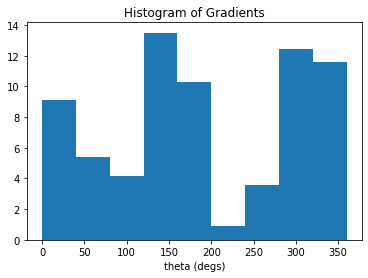

In [12]:
theta, grads_hist = gradient_histw(grads,plot=True)

print(grads_hist)
print(theta)

#### 5) Compute the gradients of the bikes1.png, graf1.png, leuven1.png and wall1.png and produce the histogram of gradients for each image.

bikes1:
{bins, hist} dict added!

graf1:
{bins, hist} dict added!

leuven1:
{bins, hist} dict added!

wall1:
{bins, hist} dict added!

dict_keys(['bikes1.png', 'graf1.png', 'leuven1.png', 'wall1.png'])


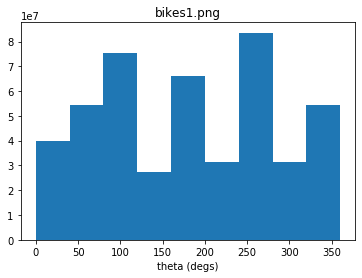

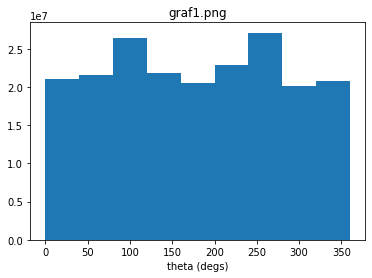

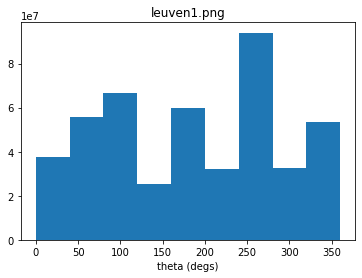

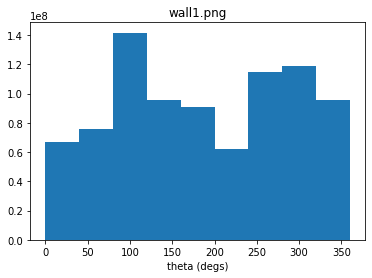

In [13]:
directory = "data/"
files = ['bikes1.png', 'graf1.png', 'leuven1.png', 'wall1.png']

grad_files = {}
for file in files:
    print(file.replace('.png', ':'))
    # compute the x and y gradients
    img = cv2.imread(directory + file, cv2.IMREAD_GRAYSCALE) # read the file in as a grayscale image
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    gradients = np.concatenate((grad_x.reshape(-1,1), grad_y.reshape(-1,1)),axis=1)
    plt.figure()
    theta, histw = gradient_histw(gradients, plot=True)
    plt.title(file)
    
    grad_files[file] = {'bins': theta, 'hist': histw}
    print('{bins, hist} dict added!')
    print()
# for
print(grad_files.keys())